# Sortify

The goal is to automatically pre-sort the playlists I regularly create for the Rock 4 Temps club parties I'm part of.

Main objectives:
* Play first the most known musics
* Alternate slow and fast music

Secondary objectives:
* Display a histogram of bpm, ideally the majority should be close to 120 (for this type of dance)
* Display the "Title - Artist" list to easily generate the PDF for the evening.

## Get tracks

In [199]:
import os

import spotipy
from spotipy.oauth2 import SpotifyOAuth

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date
from collections import Counter

### Parameters

In [200]:
# Parameters

c_id = os.environ['c_id']
c_secret = os.environ['c_secret']

playlist_id = "6FkyYOmCbQlCrWy4XZCR1Y"
# allow to ignore the N last musics 
ignore_last = 2
apply_reorder = True

In [201]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=c_id,
                                               client_secret=c_secret,
                                               redirect_uri="https://127.0.0.1",
                                               scope="""
                                               playlist-read-private playlist-modify-private playlist-modify-public 
                                               playlist-read-collaborative user-library-modify"""))

In [202]:
results = sp.current_user_playlists(limit=50)

In [203]:
# Find playlist_id if not specified

if not playlist_id:
    for playlist in results['items']:
        print(playlist['name'], playlist['id'])

In [204]:
playlist_tracks = sp.user_playlist_tracks(playlist_id=playlist_id)

In [205]:
print(playlist_tracks['items'][0].keys())
print(playlist_tracks['items'][0]['track'].keys())
print(playlist_tracks['items'][0]['track']['album'].keys())

dict_keys(['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail'])
dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'episode', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track', 'track_number', 'type', 'uri'])
dict_keys(['album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'])


In [206]:
def playlist_tracks_to_df(playlist_tracks):
    tracks = []
    for track in playlist_tracks['items']:
        t = track['track']
        features = sp.audio_analysis(t['id'])
        track = {
            'id': t['id'],
            'name': t['name'],
            'artist': ', '.join([artist['name'] for artist in t['artists']]),
            'duration_ms': t['duration_ms'],
            'explicit': t['explicit'],
            'release_date': t['album']['release_date'],
            'popularity': t['popularity'],
        }

        tracks.append(track)
    df = pd.DataFrame(tracks)
    return df

df = playlist_tracks_to_df(playlist_tracks)
df

,id,name,artist,duration_ms,explicit,release_date,popularity
0,0bI7K9Becu2dtXK1Q3cZNB,Don't Be Shy,"Tiësto, KAROL G",140500,True,2021-08-12,84
1,0yLdNVWF3Srea0uzk55zFn,Flowers,Miley Cyrus,200454,False,2023-01-13,100
2,5902W4uHWzhtOff1UK7the,When I’m Gone (with Katy Perry),"Alesso, Katy Perry",161266,False,2021-12-29,79
3,45bE4HXI0AwGZXfZtMp8JR,you broke me first,Tate McRae,169265,True,2020-04-17,84
4,3AzjcOeAmA57TIOr9zF1ZW,Physical,Dua Lipa,193829,False,2020-03-27,78
5,0U1W2LZVUX7qTm7dDpqxh6,When You're Gone,Shawn Mendes,172266,False,2022-03-31,80
6,4RAR8g8fZNB106ezUurnE0,Dancing Feet (feat. DNCE),"Kygo, DNCE",215203,False,2022-02-25,75
7,6w8pFOKn42O418qwcQElZ3,Waves,Dean Lewis,240013,False,2019-03-22,77
8,6hwQ69v7VbPhTTR2fOtYX7,Want You Bad,The Offspring,202573,False,2000-11-14,71
9,1nahzW3kfMuwReTka28tH5,Hold On,Justin Bieber,170813,False,2021-03-19,77


## Get audio features

In [207]:
features = pd.DataFrame(sp.audio_features(tracks=df['id']))
for col in ['energy', 'mode', 'tempo']:
    df[col] = features[col]
df

,id,name,artist,duration_ms,explicit,release_date,popularity,energy,mode,tempo
0,0bI7K9Becu2dtXK1Q3cZNB,Don't Be Shy,"Tiësto, KAROL G",140500,True,2021-08-12,84,0.787,0,119.986
1,0yLdNVWF3Srea0uzk55zFn,Flowers,Miley Cyrus,200454,False,2023-01-13,100,0.681,1,117.999
2,5902W4uHWzhtOff1UK7the,When I’m Gone (with Katy Perry),"Alesso, Katy Perry",161266,False,2021-12-29,79,0.886,1,125.034
3,45bE4HXI0AwGZXfZtMp8JR,you broke me first,Tate McRae,169265,True,2020-04-17,84,0.373,1,124.148
4,3AzjcOeAmA57TIOr9zF1ZW,Physical,Dua Lipa,193829,False,2020-03-27,78,0.844,1,146.967
5,0U1W2LZVUX7qTm7dDpqxh6,When You're Gone,Shawn Mendes,172266,False,2022-03-31,80,0.691,1,147.148
6,4RAR8g8fZNB106ezUurnE0,Dancing Feet (feat. DNCE),"Kygo, DNCE",215203,False,2022-02-25,75,0.797,1,105.949
7,6w8pFOKn42O418qwcQElZ3,Waves,Dean Lewis,240013,False,2019-03-22,77,0.729,0,156.879
8,6hwQ69v7VbPhTTR2fOtYX7,Want You Bad,The Offspring,202573,False,2000-11-14,71,0.966,1,105.544
9,1nahzW3kfMuwReTka28tH5,Hold On,Justin Bieber,170813,False,2021-03-19,77,0.634,0,140.002


## Sort / Reindex

In [208]:
if not apply_reorder:
    result = df

if ignore_last:
    ignored = df.iloc[-ignore_last:]
    df = df.iloc[:-ignore_last]
    print("not sorting:", ignored[['name', 'artist']])

not sorting:           name             artist
39  Dandelions            Ruth B.
40     Whisper  Burn The Ballroom


In [209]:
median_energy = np.median(df['energy'])

print(median_energy)

df = df.sort_values('popularity', ascending=False).reset_index(drop=True)

df_inf_median = df[df["energy"] < median_energy]
df_sup_median = df[df["energy"] >= median_energy]

print(df_inf_median.shape)
print(df_sup_median.shape)

0.729
(19, 10)
(20, 10)


In [210]:
ids_ordered = []

for id1, id2 in zip(df_sup_median['id'].values, df_inf_median['id'].values):
    ids_ordered.append(id1)
    ids_ordered.append(id2)

if df_inf_median.shape[0] > df_sup_median.shape[0]:
    ids_ordered.append(df_inf_median['id'].iloc[-1])
elif df_inf_median.shape[0] < df_sup_median.shape[0]:
    ids_ordered.append(df_sup_median['id'].iloc[-1])

In [211]:
if ignore_last:
    for idx in ignored['id']:
        ids_ordered.append(idx)

## Replace in Playlist

In [212]:
if apply_reorder:
    sp.playlist_replace_items(playlist_id, ids_ordered)

## See result & Generate PDF

In [213]:
if apply_reorder:
    if ignore_last:
        df = pd.concat([df, ignored])
    result = df.set_index("id")
    result = result.reindex(ids_ordered)
result

,name,artist,duration_ms,explicit,release_date,popularity,energy,mode,tempo
id,,,,,,,,,
0bI7K9Becu2dtXK1Q3cZNB,Don't Be Shy,"Tiësto, KAROL G",140500,True,2021-08-12,84,0.787,0,119.986
0yLdNVWF3Srea0uzk55zFn,Flowers,Miley Cyrus,200454,False,2023-01-13,100,0.681,1,117.999
5902W4uHWzhtOff1UK7the,When I’m Gone (with Katy Perry),"Alesso, Katy Perry",161266,False,2021-12-29,79,0.886,1,125.034
45bE4HXI0AwGZXfZtMp8JR,you broke me first,Tate McRae,169265,True,2020-04-17,84,0.373,1,124.148
3AzjcOeAmA57TIOr9zF1ZW,Physical,Dua Lipa,193829,False,2020-03-27,78,0.844,1,146.967
6Qn5zhYkTa37e91HC1D7lb,Whatever It Takes,Imagine Dragons,201240,False,2017-06-23,82,0.655,0,134.945
6w8pFOKn42O418qwcQElZ3,Waves,Dean Lewis,240013,False,2019-03-22,77,0.729,0,156.879
0U1W2LZVUX7qTm7dDpqxh6,When You're Gone,Shawn Mendes,172266,False,2022-03-31,80,0.691,1,147.148
4RAR8g8fZNB106ezUurnE0,Dancing Feet (feat. DNCE),"Kygo, DNCE",215203,False,2022-02-25,75,0.797,1,105.949


In [214]:
result.to_csv("tmp_result.csv")

In [215]:
# For easy copy pasting :)

def display(values):
    print(values[0], "-", values[1])

def display_bpm(values):
    emoji = " ⚡" if values[2] > 150 else (" 🐢" if values[2] < 105 else "")
    
    print(f"{values[0].split('(')[0]} - {values[1]}{emoji}")
    
#_ = result[['name', 'artist']].apply(display, axis=1)
_ = result[['name', 'artist', 'tempo']].apply(display_bpm, axis=1)

Don't Be Shy - Tiësto, KAROL G
Flowers - Miley Cyrus
When I’m Gone  - Alesso, Katy Perry
you broke me first - Tate McRae
Physical - Dua Lipa
Whatever It Takes - Imagine Dragons
Waves - Dean Lewis ⚡
When You're Gone - Shawn Mendes
Dancing Feet  - Kygo, DNCE
Hold On - Justin Bieber
Want You Bad - The Offspring
Potion  - Calvin Harris, Dua Lipa, Young Thug 🐢
Choke - I DONT KNOW HOW BUT THEY FOUND ME
Stole the Show - Kygo, Parson James 🐢
I Don't Like It, I Love It  - Flo Rida, Robin Thicke, Verdine White
Lost - Maroon 5
11 Minutes  - YUNGBLUD, Halsey, Travis Barker ⚡
INFERNO - Sub Urban, Bella Poarch
Take Over - League of Legends, MAX, Jeremy McKinnon of A Day To Remember, Henry
Dress - Charlotte Sands
acting like that  - YUNGBLUD, Machine Gun Kelly ⚡
Blow - Jackson Wang
I Miss the Misery - Halestorm ⚡
Rain - The Script 🐢
Would You Lie - Seeb, Alexander Stewart 🐢
Let’s Go Home Together - Ella Henderson, Tom Grennan 🐢
Sacrifice - Bebe Rexha
Don't Worry Bout Me - Zara Larsson
Bones  - Galant

# Statistics

## Alerts

In [216]:
def to_min(x):
    sec = x / 1000
    minutes = int(sec // 60)
    secondes = int(sec % 60)
    return f"{minutes}:{secondes}"
    
over4min = df[df['duration_ms'] > 4 * 60 * 1000 ]
if over4min.shape[0] > 0:
    print(f"* {over4min.shape[0]} musics over 4 minutes:")
    for i, (name, artist, ms) in enumerate(over4min[['name', 'artist', 'duration_ms']].values):
        print(f"\t{i+1}: {name} - {artist} ({to_min(ms)})")
    print()
    
expected_duration = ((2 * 60) + 10) * 60 * 1000 # 2h10
current_duration = df['duration_ms'].sum()
diff = expected_duration - current_duration
treshold = 5*60*1000

if diff > treshold:
    print(f"* Playlist too short. Add ~{to_min(diff - treshold)} of music.\n")
elif diff < treshold:
    print(f"* Playlist too long. Remove ~{to_min((diff + treshold))} of music.\n")
    
# TODO: dire quand plusieurs musiques du meme artiste

artists = []
for artist in result['artist'].values:
    if ',' in artist:
        for co_artist in artist.split(','):
            artists.append(co_artist.strip())
    else:
        artists.append(artist)
c = Counter(artists)
duplicated_artists = list(filter(lambda x: int(x[1]) > 1, c.most_common()))
if duplicated_artists:
    print("* Duplicated artists:")
    for artist, ntimes in duplicated_artists:
        print(f"  {ntimes}x {artist}")

* 3 musics over 4 minutes:
	1: Waves - Dean Lewis (4:0)
	2: Love Struck - V Factory (4:6)
	3: Whisper - Burn The Ballroom (4:58)

* Playlist too long. Remove ~-1:39 of music.

* Duplicated artists:
  2x Dua Lipa
  2x Kygo
  2x YUNGBLUD


## Informations

In [217]:
# Configure graphs style
mpl.style.use("fivethirtyeight")

In [218]:
print(f"* {round(df[df['explicit']].shape[0] / df.shape[0] * 100, 2)}% of explicit songs")

* 17.07% of explicit songs


<BarContainer object of 24 artists>

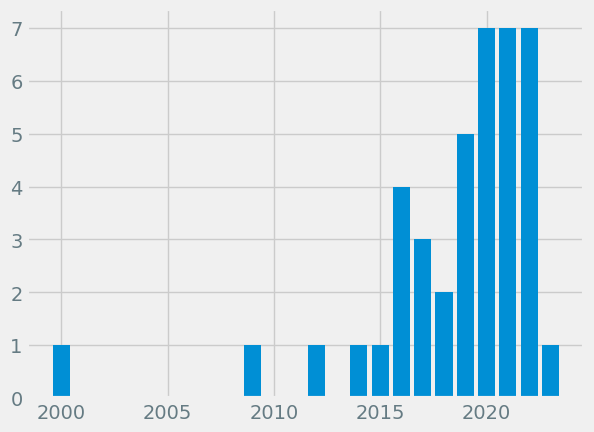

In [219]:
df['year'] = df['release_date'].apply(lambda x: x[:4])

hist = dict.fromkeys(range(int(df['year'].min()), int(df['year'].max()) + 1), 0)

def count_years(y):
    hist[int(y)] += 1

df['year'].apply(count_years)

fig, ax = plt.subplots()
ax.bar(hist.keys(), hist.values())

count     41.000000
mean     123.426561
std       23.211665
min       78.310000
25%      107.918000
50%      119.992000
75%      134.945000
max      180.001000
Name: tempo, dtype: float64


<AxesSubplot:>

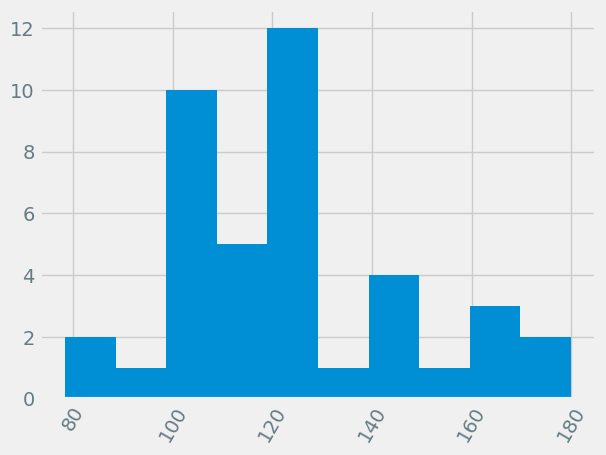

In [220]:
tempo = df['tempo'].sort_values()
print(tempo.describe())
tempo.hist(xrot=60)

<AxesSubplot:>

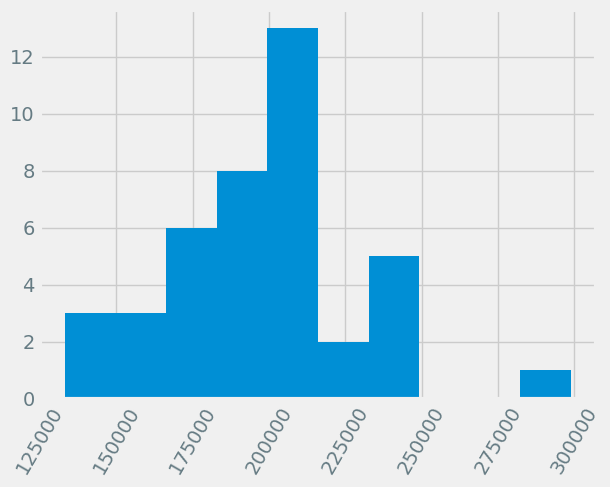

In [221]:
df['duration_ms'].sort_values().hist(xrot=60)